In [158]:
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [159]:
DATA_ROOT = Path('..') / 'data'

dfs = []
activity_labels = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in Path(DATA_ROOT).rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activity_labels[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    
    # Add a column indicating order of the activities for a particiapnt.
    df = df.sort_values(by=['time'])
    df['activity_sequence'] = (df['activity'].shift(1) != df['activity']).cumsum()
    dfs.append(df)

sensor_df = pd.concat(dfs, axis='index')
sensor_df = sensor_df.sort_values(by=['participant', 'time'])

sensor_df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant,activity_sequence
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,1,bed,M,d1p01M,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,1,bed,M,d1p01M,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,1,bed,M,d1p01M,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,1,bed,M,d1p01M,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,1,bed,M,d1p01M,1


### We need to get the length of consecutive sequences for each participant

#### Let's start with a single participant first!

In [160]:
mini = sensor_df[sensor_df['participant'] == 'd1p01M']

In [161]:
mini

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant,activity_sequence
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.42520,924.25,1,bed,M,d1p01M,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.73690,921.75,1,bed,M,d1p01M,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.03110,923.75,1,bed,M,d1p01M,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.03710,921.25,1,bed,M,d1p01M,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.89200,920.25,1,bed,M,d1p01M,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,251.00,0.87003,0.46851,0.009122,4,-58.5,0.73631,921.75,1,bed,M,d1p01M,9
397,251.25,0.87003,0.46851,0.009122,1,-57.5,0.70870,923.25,1,bed,M,d1p01M,9
398,251.50,0.87003,0.46851,0.009122,1,-59.0,0.25157,924.75,1,bed,M,d1p01M,9
399,253.25,-0.00938,0.95081,-0.116310,1,-58.5,0.35282,924.25,1,bed,M,d1p01M,9


#### function to count data point in each sequence for a single participant

In [162]:
def count_datapoints(part):
    '''takes a dataframe and returns the number of datapoints and duration for each type of sequence
    code for grouping consecutive values into sequences adapted from here https://tinyurl.com/y6gab5fh'''
    
    p_data = []

    for _, v in mini.groupby((part['activity'].shift() != part['activity']).cumsum()):
        p_data.append([v.activity.unique()[0], len(v), round(v.time.iloc[-1] - v.time.iloc[0], 3)])
        
    p_df = pd.DataFrame(p_data, columns = ['activity_type', 'number_of_measurements', 'duration'])
    
    return p_df

In [163]:
p = count_datapoints(mini)

In [164]:
p.head()

,activity_type,number_of_measurements,duration
0,1,55,37.00
1,3,117,36.50
2,1,47,27.25
3,4,4,7.50
4,2,60,77.00


#### now let's apply this to *all participants*

In [176]:
seq_df = sensor_df.groupby('participant').apply(count_datapoints).reset_index().drop(['level_1'], axis=1)

In [177]:
seq_df.head()

,participant,activity_type,number_of_measurements,duration
0,d1p01M,1,55,37.00
1,d1p01M,3,117,36.50
2,d1p01M,1,47,27.25
3,d1p01M,4,4,7.50
4,d1p01M,2,60,77.00


#### How many sequences do we have to work with? 

In [178]:
seq_df.shape

(488, 4)

### Quickest way to get a sense of what's going on with the data is still by plotting

What's the distribution of counts of sequences for all participants? 

In [191]:
part_s = seq_df.groupby('participant').describe()

In [192]:
part_s

activity_type                                               \
                    count      mean       std  min  25%  50%  75%  max   
participant                                                              
d1p01M                9.0  2.222222  1.301708  1.0  1.0  2.0  3.0  4.0   
d1p02M               11.0  1.727273  0.904534  1.0  1.0  1.0  2.5  3.0   
d1p03M                8.0  2.750000  0.707107  1.0  3.0  3.0  3.0  3.0   
d1p04M                8.0  2.500000  0.925820  1.0  2.5  3.0  3.0  3.0   
d1p05M                9.0  2.444444  0.881917  1.0  2.0  3.0  3.0  3.0   
...                   ...       ...       ...  ...  ...  ...  ...  ...   
d2p23F                9.0  1.888889  1.054093  1.0  1.0  1.0  3.0  3.0   
d2p24F                9.0  2.111111  1.054093  1.0  1.0  3.0  3.0  3.0   
d2p25F               11.0  1.727273  1.009050  1.0  1.0  1.0  3.0  3.0   
d2p26F               13.0  1.538462  0.877058  1.0  1.0  1.0  2.0  3.0   
d2p27F               12.0  2.000000  1.044466  1.0  1.0  2.0  3.0  3.0   

            number_of_measurements             ...               duration  \
                             count       mean  ...    75%    max    count   
participant                                    ...                          
d1p01M                         9.0  44.555556  ...  60.00  117.0      9.0   
d1p02M                        11.0  23.636364  ...  37.50   66.0     11.0   
d1p03M                         8.0  41.000000  ...  54.75  166.0      8.0   
d1p04M                         8.0  50.125000  ...  77.25  125.0      8.0   
d1p05M                         9.0  44.555556  ...  56.00  171.0      9.0   
...                            ...        ...  ...    ...    ...      ...   
d2p23F                         9.0  22.666667  ...  18.00  116.0      9.0   
d2p24F                         9.0  44.555556  ...  19.00  306.0      9.0   
d2p25F                        11.0  18.363636  ...  16.00   96.0     11.0   
d2p26F                        13.0  17.769231  ...  14.00   95.0     13.0   
d2p27F                        12.0  14.833333  ...  17.00   45.0     12.0   

                                                                           
                  mean        std   min      25%     50%     75%      max  
participant                                                                
d1p01M       26.786667  25.579892  0.83  4.00000  27.250  37.000   77.000  
d1p02M       13.595455  15.937479  0.00  0.50000  11.400  24.375   49.250  
d1p03M       27.121875  50.161748  0.85  1.50000   4.375  22.500  146.375  
d1p04M       31.410000  43.016993  0.85  5.89500  15.250  39.950  130.250  
d1p05M       27.623333  33.926382  0.00  2.50000  17.750  44.250  102.250  
...                ...        ...   ...      ...     ...     ...      ...  
d2p23F       10.263889  16.704599  0.00  2.75000   4.750   6.250   53.075  
d2p24F       27.705556  66.384921  0.15  2.50000   5.100   7.500  204.000  
d2p25F        7.781818  11.679405  0.00  1.27500   3.250   7.875   39.500  
d2p26F        9.530769  11.646133  0.00  3.75000   5.025   9.000   37.750  
d2p27F        6.106250   4.683386  0.50  3.04375   4.250  10.375   14.750  

[87 rows x 24 columns]

#### Get an idea of the distribution of numbers of sequences in all particpants


<AxesSubplot:>

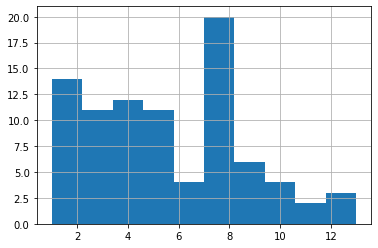

In [193]:
part_s['activity_type']['count'].hist()

#### how many do we have of each sequence in total?

type 4 might prove problematic if also few datapoints...

In [190]:
seq_df.groupby('activity_type').count()

,participant,number_of_measurements,duration
activity_type,,,
1,244,244,244
2,50,50,50
3,185,185,185
4,9,9,9


### Get a histogram of number of measurements & durations for types of activity

reminder: activity_labels = ['bed', 'chair', 'lying', 'ambulating']

<AxesSubplot:>

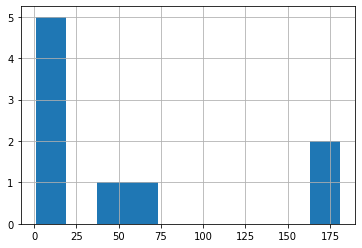

In [213]:
seq_df[seq_df['activity_type'] == 4]['number_of_measurements'].hist()

<AxesSubplot:>

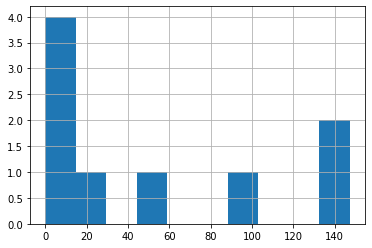

In [212]:
seq_df[seq_df['activity_type'] == 4]['duration'].hist()

#### Descriptives by activity type

In [214]:
a_desc = seq_df.groupby('activity_type').describe()

a_desc

number_of_measurements                                        \
                               count       mean        std  min  25%   50%   
activity_type                                                                
1                              244.0  59.676230  93.508817  1.0  4.0  12.0   
2                               50.0  49.620000  63.347725  1.0  2.0  11.0   
3                              185.0  39.270270  58.465453  1.0  4.0  11.0   
4                                9.0  55.111111  75.118980  1.0  3.0   9.0   

                             duration                                     \
                  75%    max    count       mean        std  min     25%   
activity_type                                                              
1               77.75  401.0    244.0  35.919693  59.526859  0.0  1.7500   
2              116.00  176.0     50.0  37.959200  45.458751  0.0  0.8125   
3               52.00  306.0    185.0  20.631000  40.131614  0.0  1.0800   
4               72.00  181.0      9.0  52.475556  61.806465  0.0  3.7500   

                                       
                 50%      75%     max  
activity_type                          
1               6.55  43.0625  254.00  
2               8.00  85.0625  136.00  
3               4.25  19.5000  204.00  
4              20.25  94.2800  147.25

#### Descriptives for activity type by participant

In [217]:
pa_desc = seq_df.groupby(['participant', 'activity_type']).describe().reset_index()

pa_desc

participant activity_type number_of_measurements                         \
                                               count        mean        std   
0        d1p01M             1                    4.0   28.500000  26.236107   
1        d1p01M             2                    1.0   60.000000        NaN   
2        d1p01M             3                    2.0  110.000000   9.899495   
3        d1p01M             4                    2.0    3.500000   0.707107   
4        d1p02M             1                    6.0   31.000000  24.576411   
..          ...           ...                    ...         ...        ...   
170      d2p26F             1                    9.0   22.111111  28.576408   
171      d2p26F             2                    1.0    1.000000        NaN   
172      d2p26F             3                    3.0   10.333333   6.429101   
173      d2p27F             1                    6.0   16.000000  15.019987   
174      d2p27F             3                    6.0   13.666667   9.993331   

                                         duration                        \
       min     25%    50%     75%    max    count       mean        std   
0      4.0    7.00   27.5   49.00   55.0      4.0  17.270000  17.656347   
1     60.0   60.00   60.0   60.00   60.0      1.0  77.000000        NaN   
2    103.0  106.50  110.0  113.50  117.0      2.0  41.875000   7.601398   
3      3.0    3.25    3.5    3.75    4.0      2.0   5.625000   2.651650   
4      2.0   11.25   37.5   39.75   66.0      6.0  20.958333  18.272532   
..     ...     ...    ...     ...    ...      ...        ...        ...   
170    3.0    9.00   12.0   14.00   95.0      9.0  12.594444  12.908535   
171    1.0    1.00    1.0    1.00    1.0      1.0   0.000000        NaN   
172    3.0    8.00   13.0   14.00   15.0      3.0   3.516667   2.316022   
173    3.0    8.25   11.5   16.25   45.0      6.0   7.791667   5.249802   
174    4.0    8.00   11.0   15.50   32.0      6.0   4.420833   3.725199   

                                               
       min       25%     50%      75%     max  
0     0.83   3.20750  15.625  29.6875  37.000  
1    77.00  77.00000  77.000  77.0000  77.000  
2    36.50  39.18750  41.875  44.5625  47.250  
3     3.75   4.68750   5.625   6.5625   7.500  
4     0.50   6.68750  24.375  25.9375  49.250  
..     ...       ...     ...      ...     ...  
170   1.50   4.25000   8.000  10.2500  37.750  
171   0.00   0.00000   0.000   0.0000   0.000  
172   0.85   2.76250   4.675   4.8500   5.025  
173   0.50   4.50000   8.000  11.1250  14.750  
174   1.40   2.13125   3.675   4.3375  11.600  

[175 rows x 18 columns]